In [ ]:
import pandas as pd

# Load CSVs or data sources
email_df = pd.read_csv('/content/email_table.csv')
opened_df = pd.read_csv('/content/email_opened_table.csv')
clicked_df = pd.read_csv('/content/link_clicked_table.csv')

# Preview datasets
print(email_df.head())
print(opened_df.head())
print(clicked_df.head())


   email_id   email_text email_version  hour    weekday user_country  \
0     85120  short_email  personalized     2     Sunday           US   
1    966622   long_email  personalized    12     Sunday           UK   
2    777221   long_email  personalized    11  Wednesday           US   
3    493711  short_email       generic     6     Monday           UK   
4    106887   long_email       generic    14     Monday           US   

   user_past_purchases  
0                    5  
1                    2  
2                    2  
3                    1  
4                    6  
   email_id
0    284534
1    609056
2    220820
3    905936
4    164034
   email_id
0    609056
1    870980
2    935124
3    158501
4    177561


In [2]:
email_df['opened'] = email_df['email_id'].isin(opened_df['email_id']).astype(int)
email_df['clicked'] = email_df['email_id'].isin(clicked_df['email_id']).astype(int)

In [3]:
open_rate = email_df['opened'].mean()
click_rate = email_df['clicked'].mean()

print(f"Open Rate: {open_rate:.2%}")
print(f"Click-Through Rate (CTR): {click_rate:.2%}")

Open Rate: 10.35%
Click-Through Rate (CTR): 2.12%


In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

# Select features and target
features = email_df[['email_text', 'email_version', 'hour', 'weekday', 'user_country', 'user_past_purchases']]
target = email_df['clicked']

# One-hot encode categorical variables
features_encoded = pd.get_dummies(features, drop_first=True)

# Split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(features_encoded, target, test_size=0.3, random_state=42)

In [11]:
from xgboost import XGBClassifier

# Use scale_pos_weight to balance the classes
scale = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',
                          scale_pos_weight=scale, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print(f"ROC AUC: {roc_auc_score(y_test, y_proba):.2f}")

C:\Users\u19cs\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\xgboost\training.py:183: UserWarning: [09:19:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


              precision    recall  f1-score   support

           0       0.98      0.74      0.84     29326
           1       0.04      0.48      0.08       674

    accuracy                           0.73     30000
   macro avg       0.51      0.61      0.46     30000
weighted avg       0.96      0.73      0.83     30000

ROC AUC: 0.68


In [20]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

def plot_threshold_curve(y_true, y_proba):
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)

    plt.figure(figsize=(8,5))
    plt.plot(thresholds, precision[:-1], label='Precision')
    plt.plot(thresholds, recall[:-1], label='Recall')
    plt.xlabel('Threshold')
    plt.ylabel('Score')
    plt.title('Precision and Recall vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()

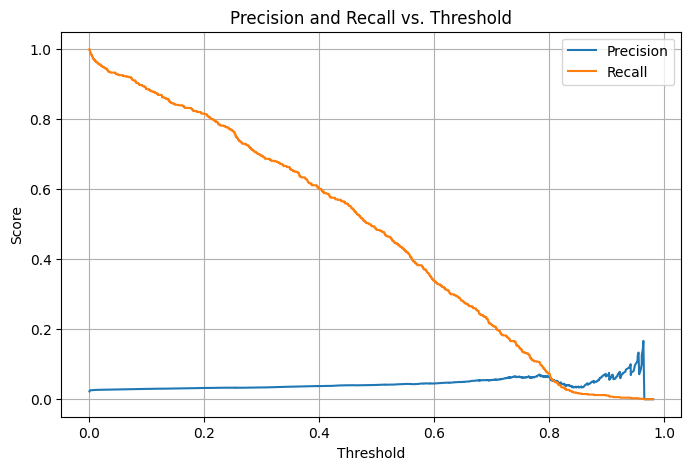

In [21]:
plot_threshold_curve(y_test, y_proba)

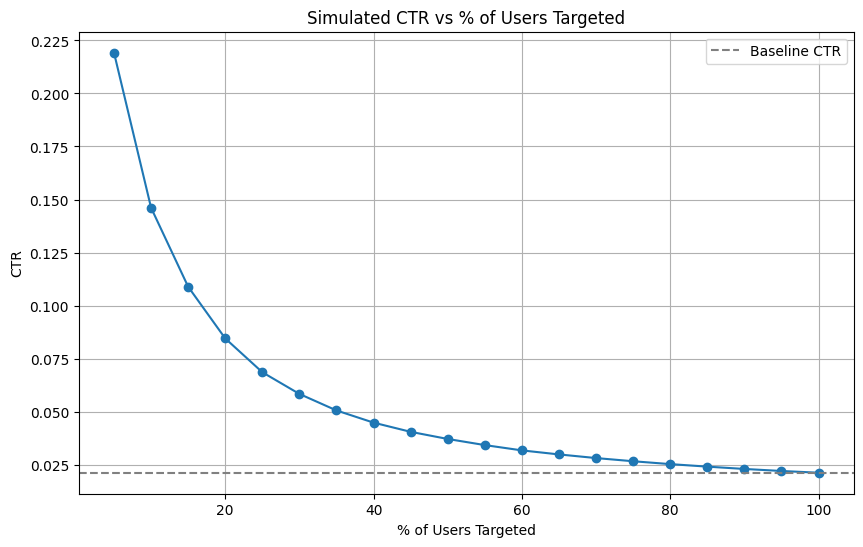

In [46]:
import matplotlib.pyplot as plt

percentages = list(range(5, 101, 5))  # 5% to 100%
ctrs = []

for pct in percentages:
    cutoff = int(len(email_df) * pct / 100)
    top_users = email_df.sort_values(by='predicted_proba', ascending=False).head(cutoff)
    ctr = top_users['clicked'].mean()
    ctrs.append(ctr)

plt.figure(figsize=(10, 6))
plt.plot(percentages, ctrs, marker='o')
plt.axhline(y=click_rate, color='gray', linestyle='--', label='Baseline CTR')
plt.title('Simulated CTR vs % of Users Targeted')
plt.xlabel('% of Users Targeted')
plt.ylabel('CTR')
plt.legend()
plt.grid(True)
plt.show()

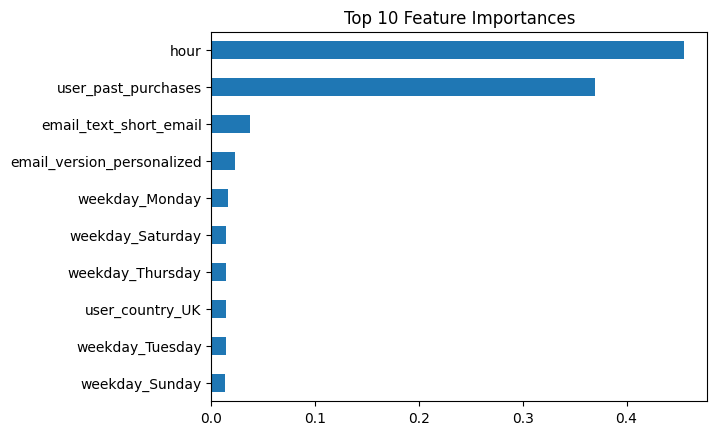

In [8]:
# Feature importance
import matplotlib.pyplot as plt
import seaborn as sns

importances = pd.Series(model.feature_importances_, index=features_encoded.columns)
importances.sort_values().tail(10).plot(kind='barh')
plt.title("Top 10 Feature Importances")
plt.show()

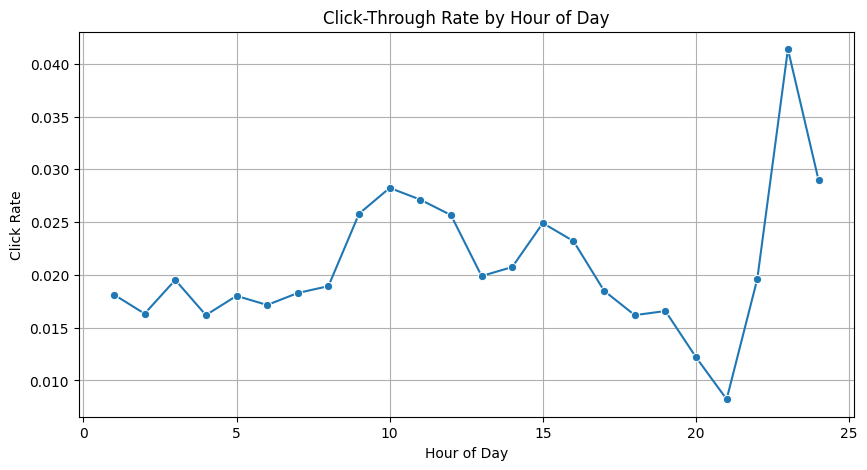

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

click_rate_by_hour = email_df.groupby('hour')['clicked'].mean()

plt.figure(figsize=(10,5))
sns.lineplot(x=click_rate_by_hour.index, y=click_rate_by_hour.values, marker='o')
plt.title('Click-Through Rate by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Click Rate')
plt.grid(True)
plt.show()


ctr_by_hour = email_df.groupby('hour')['clicked'].mean()
print(ctr_by_hour.sort_values(ascending=False).head(5))  # Top-performing hours

C:\Users\u19cs\AppData\Local\Temp\ipykernel_13260\1156791883.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  click_rate_by_purchase = email_df.groupby('purchase_bin')['clicked'].mean()


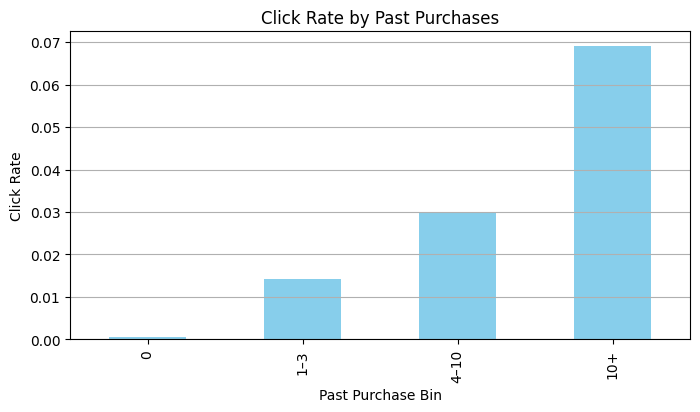

In [ ]:
# You can also bin purchase history
email_df['purchase_bin'] = pd.cut(email_df['user_past_purchases'], bins=[-1, 0, 3, 10, float('inf')], labels=['0', '1–3', '4–10', '10+'])

click_rate_by_purchase = email_df.groupby('purchase_bin')['clicked'].mean()

plt.figure(figsize=(8,4))
click_rate_by_purchase.plot(kind='bar', color='skyblue')
plt.title('Click Rate by Past Purchases')
plt.xlabel('Past Purchase Bin')
plt.ylabel('Click Rate')
plt.grid(axis='y')
plt.show()


email_df['purchase_bin'] = pd.cut(email_df['user_past_purchases'], bins=[-1, 0, 3, 10, float('inf')],
                            labels=['0', '1–3', '4–10', '10+'])

ctr_by_purchase = email_df.groupby('purchase_bin')['clicked'].mean().sort_index()
print(ctr_by_purchase)

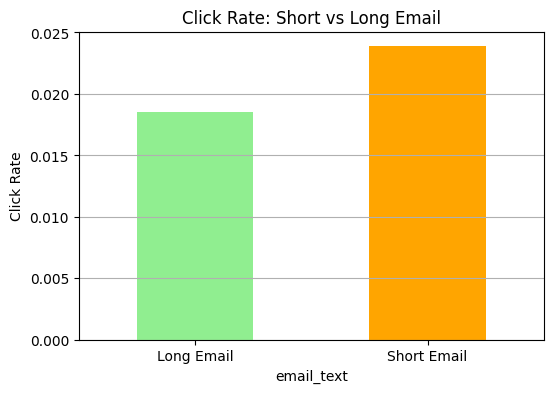

In [ ]:
click_rate_by_length = email_df.groupby('email_text')['clicked'].mean()

plt.figure(figsize=(6,4))
click_rate_by_length.plot(kind='bar', color=['lightgreen', 'orange'])
plt.title('Click Rate: Short vs Long Email')
plt.xticks([0, 1], ['Long Email', 'Short Email'], rotation=0)
plt.ylabel('Click Rate')
plt.grid(axis='y')
plt.show()

ctr_by_text_length = email_df.groupby('email_text')['clicked'].mean()
ctr_by_text_length.index = ['Long', 'Short']
print(ctr_by_text_length)


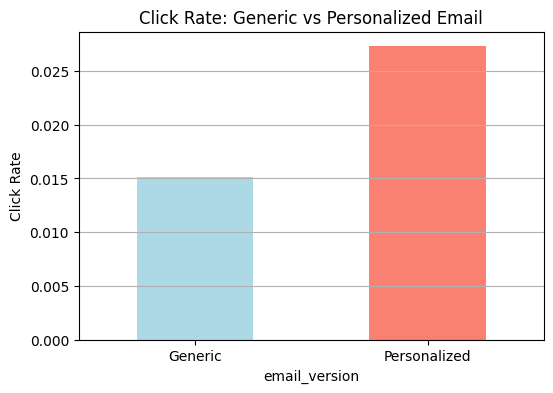

In [ ]:
click_rate_by_personalization = email_df.groupby('email_version')['clicked'].mean()

plt.figure(figsize=(6,4))
click_rate_by_personalization.plot(kind='bar', color=['lightblue', 'salmon'])
plt.title('Click Rate: Generic vs Personalized Email')
plt.xticks([0, 1], ['Generic', 'Personalized'], rotation=0)
plt.ylabel('Click Rate')
plt.grid(axis='y')
plt.show()

ctr_by_personalization = email_df.groupby('email_version')['clicked'].mean()
ctr_by_personalization.index = ['Generic', 'Personalized']
print(ctr_by_personalization)


In [47]:
top_countries = email_df['user_country'].value_counts().head(5).index
ctr_by_country = email_df[email_df['user_country'].isin(top_countries)].groupby('user_country')['clicked'].mean()
print(ctr_by_country.sort_values(ascending=False))

ctr_by_day = email_df.groupby('weekday')['clicked'].mean()
print(ctr_by_day.sort_values(ascending=False))

user_country
UK    0.024675
US    0.024360
ES    0.008327
FR    0.008004
Name: clicked, dtype: float64
weekday
Wednesday    0.027620
Tuesday      0.024889
Thursday     0.024445
Monday       0.022906
Saturday     0.017846
Sunday       0.016751
Friday       0.014037
Name: clicked, dtype: float64
